# Polynomial Support Vector Machines

Now that you have the basics of SVMs down, let's take a look at how to tweak the model. In this lecture I want to start by tackling the question of a linear hyperplane. Up until now we've tried to separate these two kinds of pitches, fastballs and curveballs, using just two features, spin and effective speed, and to do so with a straight line. But sometimes a linear hyperplan doesn't make the best sense. SVMs have two ways of dealing with this. The first is to put the effort on you as the data scientist, and have you modify your features using some non-linear preprocessing step. You've probably seen this before, when people take the natural log, for instance, of a value when plotting it to reveal a new linear trend. This works well, and is applicable to many machine learning methods. But we can also directly tell the sklearn SVC that we want to use a non-linear kernel.

In [2]:
# Let's see how this works with the pitching data we were looking at previously.
# We bring in our data science imports first
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from sklearn import svm

# Then we bring in our dataset
#filename="assets/baseball_svm_data.zip"
df=pd.read_csv("D:\\GitHub\\Coursera\\SportsPerformanceAnalytics\\IntroductiontoMachineLearninginSportsAnalytics\\data\\reg_Sep2019.csv")

# And we clean it up a bit just for this task
df=df[df["pitch_type"].isin(["FT","CU"])]
df["color"]="blue"
df.loc[df["pitch_type"]=="CU","color"]="orange"
df=df[["effective_speed", "release_spin_rate", "color", "pitch_type"]]
df=df.dropna()

# And we'll intersperse our classes for rendering later
df=df.groupby("pitch_type").apply(lambda x: x.reset_index(drop=True)).reset_index(0,drop=True).sort_index()
df.head()

,effective_speed,release_spin_rate,color,pitch_type
0,84.651,2602.0,orange,CU
0,92.116,2127.0,blue,FT
1,90.044,1985.0,blue,FT
1,83.118,2627.0,orange,CU
2,81.793,2668.0,orange,CU


In [3]:
# Now, it's actually pretty straightforward to fit a polynomial classifier, the
# most important concern is actually on over training on your data. The issue is that
# we would expect that a very high degree polynomial hypyerplane - a really wavy
# line - is likely to work poorly for new data which is near the street. Sklearn allows
# us to choose the degree of the polynomial function we want to fit

# Let's create a polynomial classifier with a degree of 5
clf=svm.SVC(kernel='poly', degree=5, random_state=1337)

# I'm going to use a third party function to show the descision boundary instead of
# plotting that hyperplane myself. Unfortunately this library requires out target y
# to be numeric, so I'm going to change the pitch_type using the pandas factorize()
# function. This just changes everything to a 0 or 1
df["pitch_type"]=df["pitch_type"].factorize()[0]

# And we're just going to look at the first thousand entries
df=df[0:999]

# Now before we fit (or train) this model we need to make our train/test splits. Sklearn
# has a handy helper function fof this, which allows us to do this in one line. We set
# a random state here too, as sklearn is going to randomly sample these values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[["effective_speed", "release_spin_rate"]],
    df["pitch_type"],
    test_size=0.2,
    random_state=1337)

# And first up we'll fit and score the accuracy of this model
print(clf.fit(X_train, y_train).score(X_test, y_test))

0.9


In [4]:
# Hrm. The accuracy is 90% which sounds nice, but wasn't the linear SVM almost perfect?
# Let's quickly build that model too, with the same partitioned data here in case that
# has something to do with it
clf=svm.SVC(kernel='linear', random_state=1337)
print(clf.fit(X_train, y_train).score(X_test, y_test))

0.995


c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


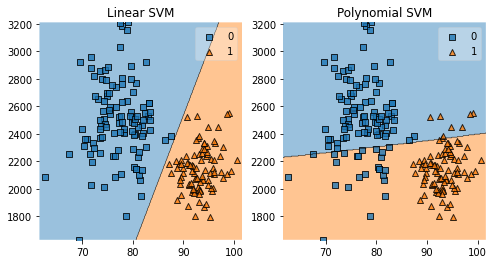

In [6]:
# So, this doesn't ssem like much of an improvement. Let's look at these two
# models side by side visually
fig, axes = plt.subplots(1,2, figsize=(8,4))

# Let's parameterize and fit our two models
clf_linear=svm.SVC(kernel='linear', random_state=1337)
clf_linear.fit(X_test,y_test)
clf_poly5=svm.SVC(kernel='poly', degree=5, random_state=1337)
clf_poly5.fit(X_test,y_test)

# Now let's plot the descision regions, using the nice work of Sebastian Raschka
# at the University of Wisonsin - Madison
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), clf_linear, ax=axes[0])
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), clf_poly5, ax=axes[1])
axes[0].set_title("Linear SVM")
axes[1].set_title("Polynomial SVM");

c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: 

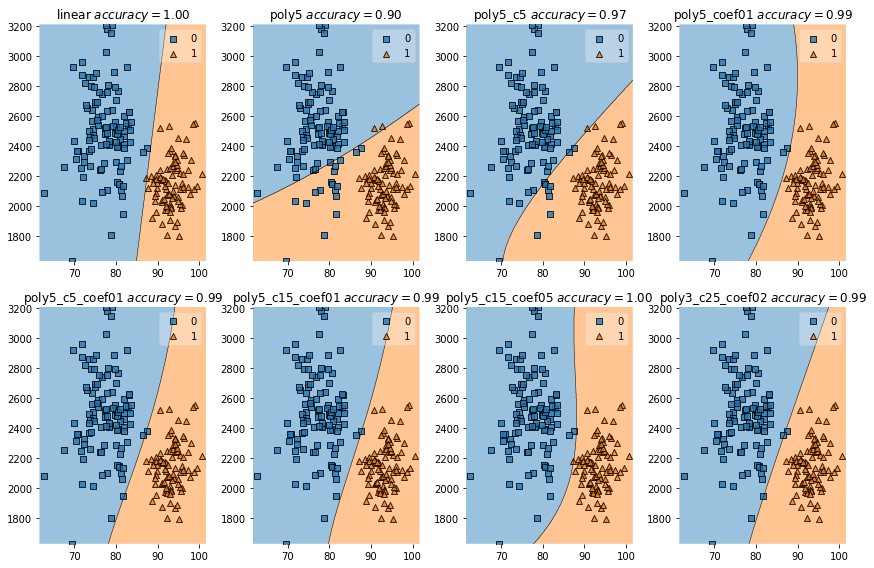

In [7]:
# So we can see that the Polynomial SVM we fit is really poor. It does have some
# accuracy greater than chance -- there are only a few triangles above the descision
# boundary -- but it is really making a poor choice for what appears to be a
# straight hyperplane. The polynomial kernel is actually further parameterized, and
# in this example we only set the degree of the curve. Two other features are
# pretty impactful: C, which is the regularization parameter, and coef0, which is
# the independent term in the kernel function. There are other parameterizations,
# but you can condiser these two values as a good place to start. Setting C values
# penalizes the model for creating highly specific (and thus not generalizable)
# models. The coef0 parameter has the opposite approach, and controls how much the
# model is influenced by high defree polynomial functions. Let's try a few different
# values
fig, axes = plt.subplots(2,4, figsize=(12,8))

clfs={}
# Let's parameterize and fit our two models
clfs["linear"]=svm.SVC(kernel='linear', random_state=1337)
clfs["poly5"]=svm.SVC(kernel='poly', degree=5, random_state=1337)
clfs["poly5_c5"]=svm.SVC(kernel='poly', degree=5, C=5, random_state=1337)
clfs["poly5_coef01"]=svm.SVC(kernel='poly', degree=5, coef0=5, random_state=1337)
clfs["poly5_c5_coef01"]=svm.SVC(kernel='poly', degree=5, C=5, coef0=1, random_state=1337)
clfs["poly5_c15_coef01"]=svm.SVC(kernel='poly', degree=5, C=15, coef0=1, random_state=1337)
clfs["poly5_c15_coef05"]=svm.SVC(kernel='poly', degree=5, C=15, coef0=5, random_state=1337)
clfs["poly3_c25_coef02"]=svm.SVC(kernel='poly', degree=3, C=25, coef0=2, random_state=1337)

i=1
j=0
for label, model in clfs.items():
    text=f"{label} $accuracy={model.fit(X_train,y_train).score(X_train,y_train):.2f}$"
    plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), model, ax=axes[int(np.ceil(i/4)-1)][j%4])
    axes[int(np.ceil(i/4)-1)][j%4].set_title(text)
    i=i+1
    j=j+1

plt.tight_layout()

Wow, there's a lot to digest here. We've tried a bunch of different models, and have two that fit really well, the linear SVM and the polynomial degree 5 SVM with `C=15` and `coef0=5`. So, is this the best approach, just guess and test a bunch of parameters to determine which models work the best?

The answer is a bit complex. At a high level no, you want to leverage your knowledge of the problem, the data, and the algorithms to make an informed understanding of how to parameterize the model. Ideally you want a simple model, and it seems pretty clear in this case the linear SVM is that! And you need to keep in mind that high level machine learning workflow we spoke of at the beginning of the course - if you are constantly looking at the results of your test set, then you are actually having your model learn information about that set, and the model isn't going to be predictive if used on future data.

There are some really interesting methods though, from trying to learn your hyperparameter values and then use them on a final holdout set. The most common of these which I see used is the grid search, which is an exhaustive search of the parameter space - or at least an exhaustive enough search depending on how many resources and how much time you want to allocate to it - and the results are pretty nice. But let's not go there yet, let's look at this hyperplane a bit more instead.